# Cross-section blob detection based on Otsu segmentation
This notebook aims to get some insight of cross section blob detection. For convinence, we start with otsu threshold. Better segmentation method can be modified later.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 1
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
import scipy
import skimage
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *



Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [2]:
%autoreload 1
save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_single_sec/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Bolb_detection_single_sec/

In [68]:
def fun_radius_bbox(min_row, min_col, max_row, max_col):
    """
    radisu_bbox(min_row, min_col, max_row, max_col), correspond to the order of regionprops.bbox tuple
    """
    radius = 0.5 * ((max_col - min_col)**2 + (max_row - min_row)**2) ** 0.5
    return radius

In [326]:
def fun_crop_images(image, min_row, min_col, max_row, max_col, margin=0,imrmax=10000,imcmax=10000):
    min_row = max(min_row-margin,0)
    max_row = min(max_row+margin,imrmax)
    min_col = max(min_col-margin,0)
    max_col = min(max_col+margin,imcmax)
    crop_image = image[min_row:max_row, min_col:max_col]
#     print((min_row, min_col, max_row, max_col))
    return crop_image

In [364]:
def fun_scan_range(cloc,radius,imcmax=10000,imrmax=10000):
    cloc = np.array(cloc);
    min_row = int(max(np.round(cloc - radius)[0],0))
    min_col = int(max(np.round(cloc - radius)[1],0))
    max_row = int(min(np.round(cloc + radius)[0],imrmax))
    max_col = int(min(np.round(cloc + radius)[1],imcmax))
    local_cloc = (int(cloc[0] - min_row), int(cloc[1] - min_col))
    return (min_row, min_col, max_row, max_col), local_cloc

In [386]:
def fun_local_distance(blob_loc_tuple, local_cloc_tuple):
    r = ((blob_loc_tuple[0] - local_cloc_tuple[0]) ** 2 + ((blob_loc_tuple[1] - local_cloc_tuple[1]) ** 2) ) ** 0.5
    return r

In [449]:
def fun_similarity(oriIprops,nextIprops,distance_type='euclid'):
    similarity = [];
    num_blob = len(nextIprops);
    pi = 3.1415926
    for i in range(num_blob):
        if distance_type == 'euclid':
            difference = abs(oriIprops - nextIprops[i])/float(max(oriIprops, nextIprops[i]))
        elif distance_type == 'angular':
            diff_angle = abs(oriIprops - nextIprops[i])
            diff_angle = min(diff_angle, pi - diff_angle )
            difference = np.cos(diff_angle)
        similarity.append( 1 - difference) 
    return similarity


In [78]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 448
patch_half_size = patch_size / 2
stride = 112
# Crop images
# 
# crop_x_min = 9000
# crop_x_max = 10500
# crop_y_min = 3000
# crop_y_max = 4500

# Inside
crop_x_min = 4000
crop_x_max = 6000
crop_y_min = 2400
crop_y_max = 4400

# Whole
# crop_x_min = 0
# crop_y_min = 0
# _, _, crop_y_max, crop_x_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
imrmax = crop_y_max - crop_y_min
imcmax = crop_x_max - crop_x_min
crop_image_width = crop_y_max - crop_y_min
crop_image_height = crop_x_max - crop_x_min

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, crop_image_width, crop_image_height ))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

In [4]:
# Set examine section number range and download from S3 if not available
img_filename = []
secIndexList = range(200, 206)

for tempIndex1 in range(len(secIndexList)):
    img_filename.append(DataManager.get_image_filepath(stack=stack, section=secIndexList[tempIndex1], resol='lossless', version='cropped'))
    if os.path.isfile(img_filename[tempIndex1]):
        sys.stderr.write('Image files are already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempIndex1])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            continue           

Image files are already available. 
Image files are already available. 
Image files are already available. 
Image files are already available. 
Child returned 0


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N37-2015.07.30-18.32.51_MD589_2_0110_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N37-2015.07.30-18.32.51_MD589_2_0110_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N37-2015.07.30-18.32.51_MD589_2_0110_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
4.03 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC37-2015.07.30-23.50.39_MD589_2_0110_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC37-2015.07.30-23.50.39_MD589_2_0110_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC37-2015.07.30-23.50.39_MD589_2_0110_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
4.01 seconds.


In [159]:
range(len(img_filename))

[0, 1, 2, 3, 4, 5]

In [162]:
option_rescale_grayscale = True
option_inverse_color = False
secIndex = 0

n_images = len(img_filename)
im_cropped = []
im_rescale = []
for imIndex in range(n_images):
    im_cropped.append(img_as_ubyte(rgb2gray(imread(img_filename[imIndex])[crop_x_min:crop_x_max, crop_y_min:crop_y_max])))
    if option_rescale_grayscale:
        im_rescale.append(fun_rescale_grayscale_image(im_cropped[imIndex],invcol=option_inverse_color))

im_cropped_h, im_cropped_w = im_cropped[0].shape[:2]

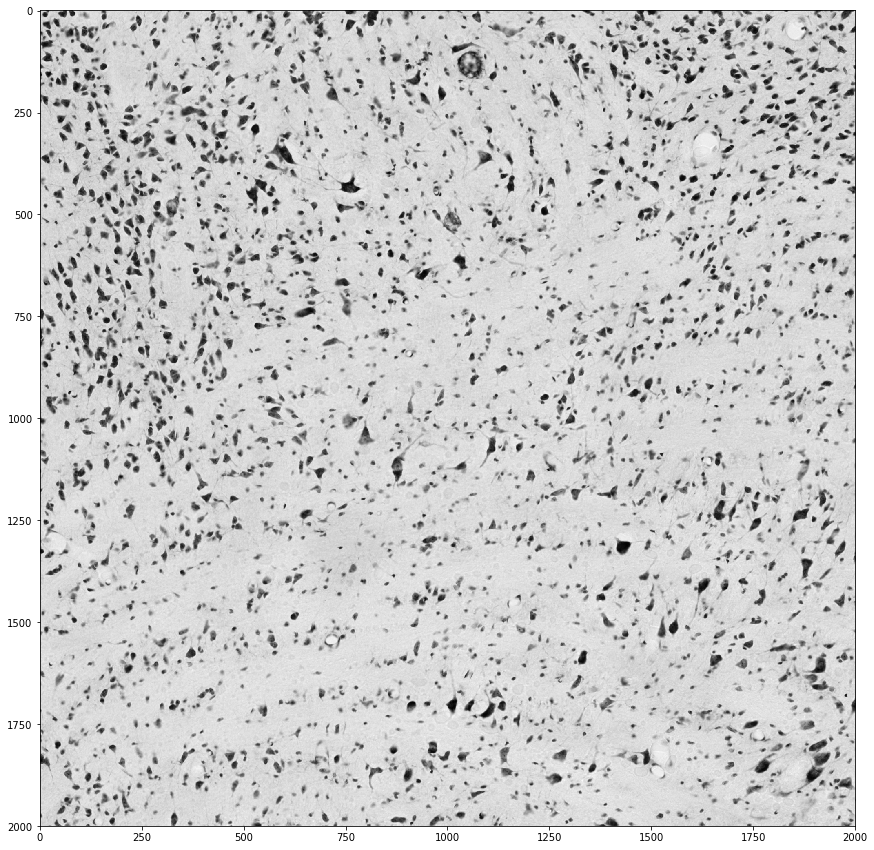

In [166]:
# Example image
plt.figure(figsize=(15,15))
plt.imshow(im_rescale[secIndex],cmap=plt.cm.gray)

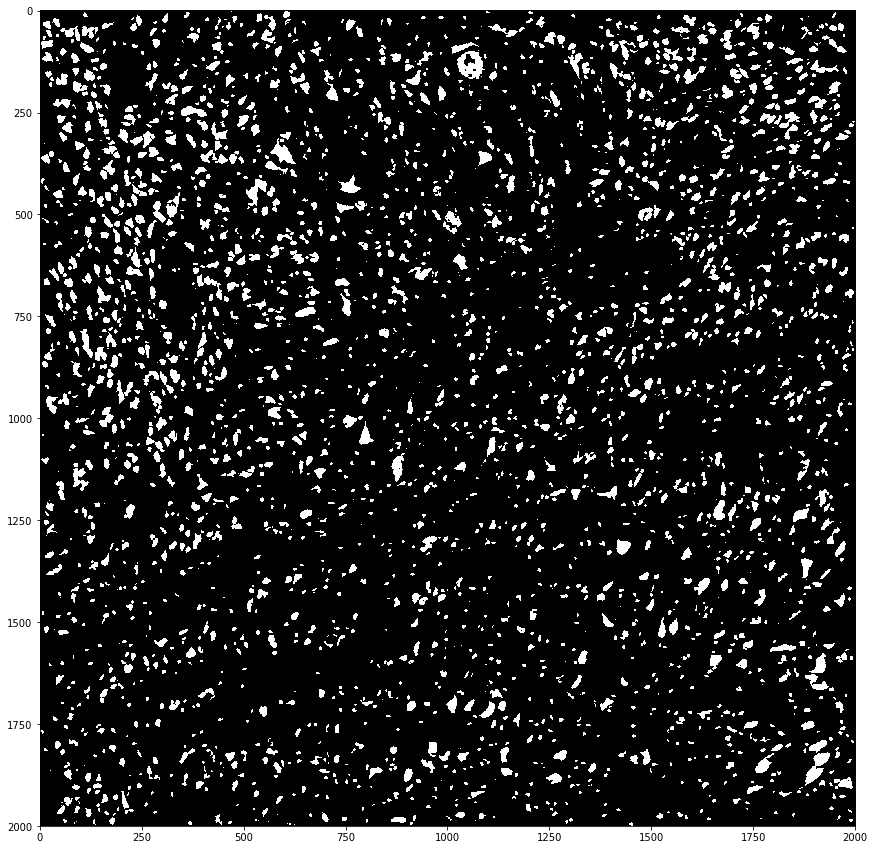

In [172]:
otsu_thresh = []
im_BW = []
im_label = []
option_clear_BW_border = True
option_label_num_neighbor = 4
im_blob_prop = {}
for imIndex in range(n_images):
    otsu_thresh.append(skimage.filters.threshold_otsu(im_rescale[imIndex]))
    im_BW.append(im_rescale[imIndex] < otsu_thresh[imIndex])
    if option_clear_BW_border:
        im_BW[imIndex] = skimage.segmentation.clear_border(im_BW[imIndex])
    im_label.append(skimage.measure.label(im_BW[imIndex],neighbors=option_label_num_neighbor))
    im_blob_prop[secIndexList[imIndex]] = skimage.measure.regionprops(im_label[imIndex])
    
# Example: 
im_temp_BW = plt.figure(figsize=(15,15))
im_temp_BW = plt.imshow(im_BW[secIndex],cmap=plt.cm.gray);

In [492]:
secIndex = 0
sec = secIndexList[secIndex]
blobID = 142
n_blobs = len(im_blob_prop[sec])

im_blob_typical = {}
for tempSecIndex in range(n_images):
    tempSec = secIndexList[tempSecIndex]
    tempN_blobs = len(im_blob_prop[tempSec])
    im_blob_typical[tempSec] = np.zeros((tempN_blobs,1),dtype=bool)


In [493]:
tempRegion1 = im_blob_prop[sec][blobID]

In [494]:
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox']

temp_curr_blob_props = {}

for tempProp in prop:
    temp_curr_blob_props[tempProp] = tempRegion1[tempProp]

tempR1_radius = fun_radius_bbox(*temp_curr_blob_props['bbox'])
tempR1_idx_loc = temp_curr_blob_props['centroid']
tempR1_orientation = temp_curr_blob_props['orientation']
tempR1_hu = temp_curr_blob_props['moments_hu']
tempR1_size = temp_curr_blob_props['area']

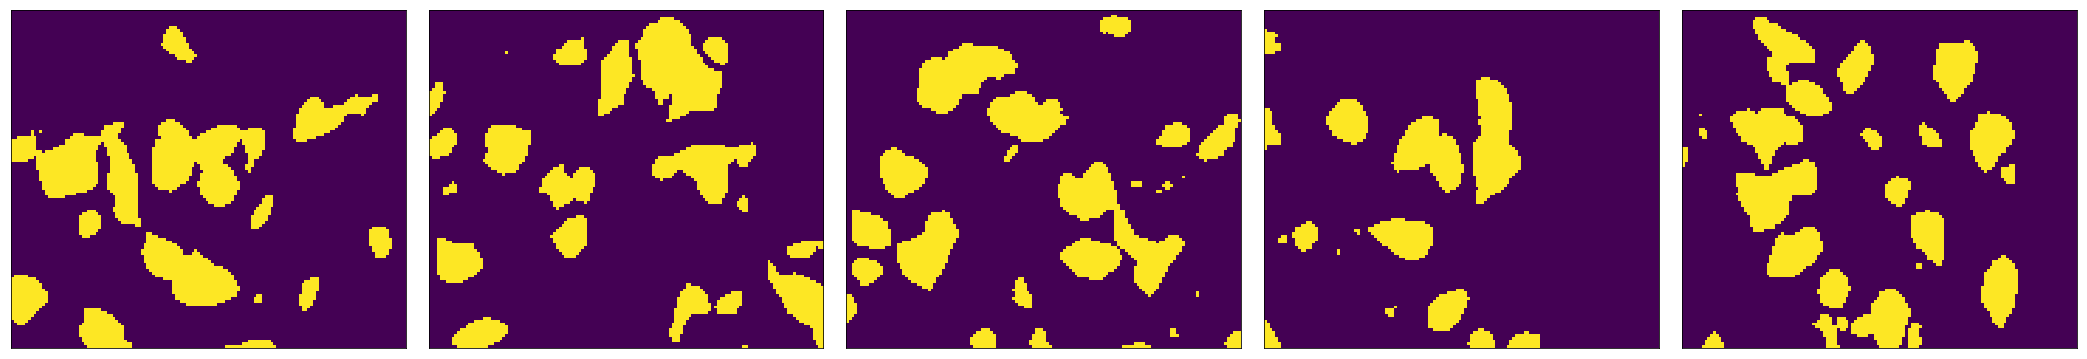

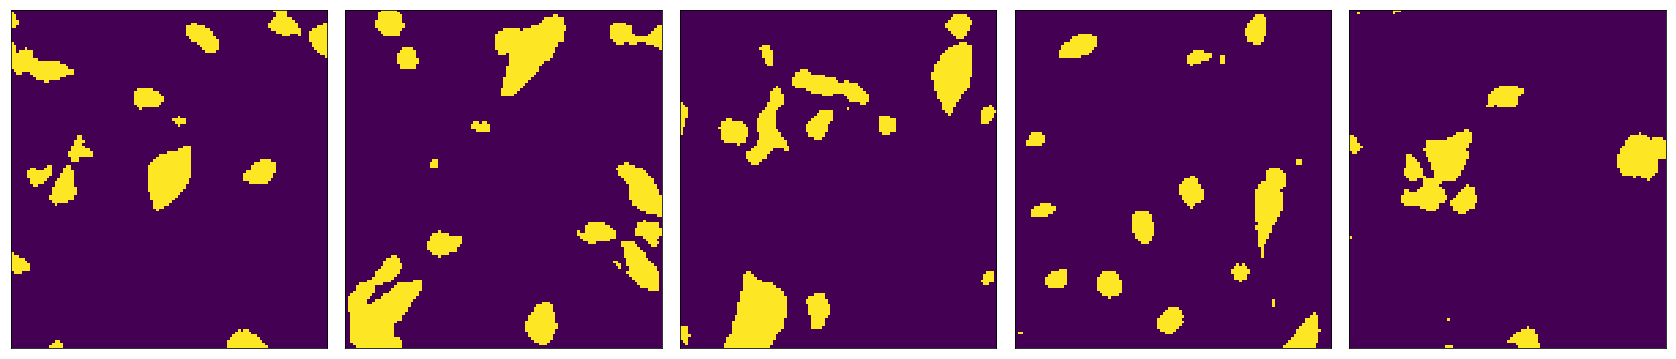

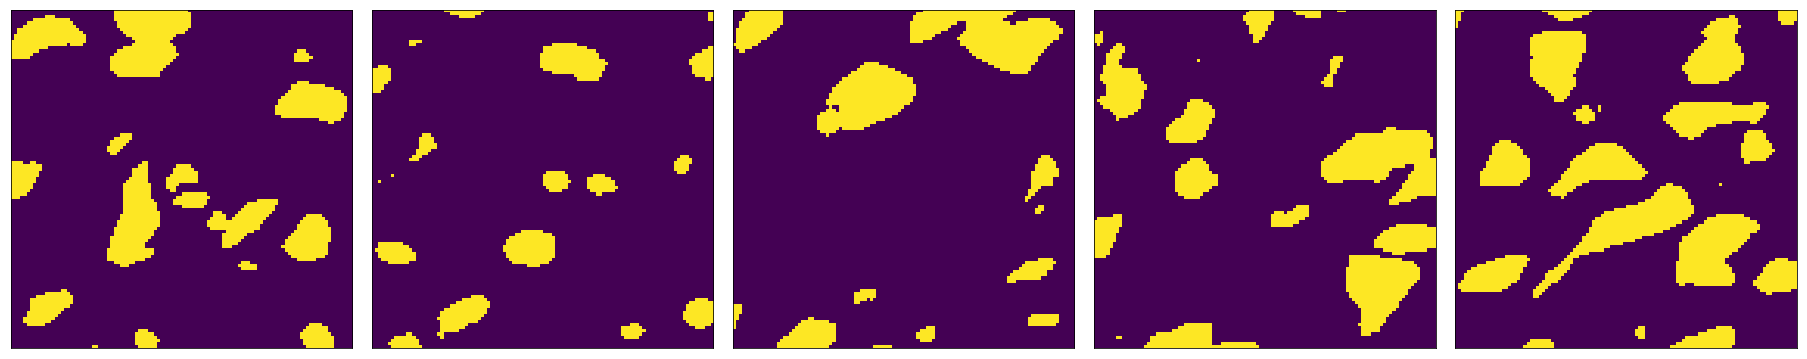

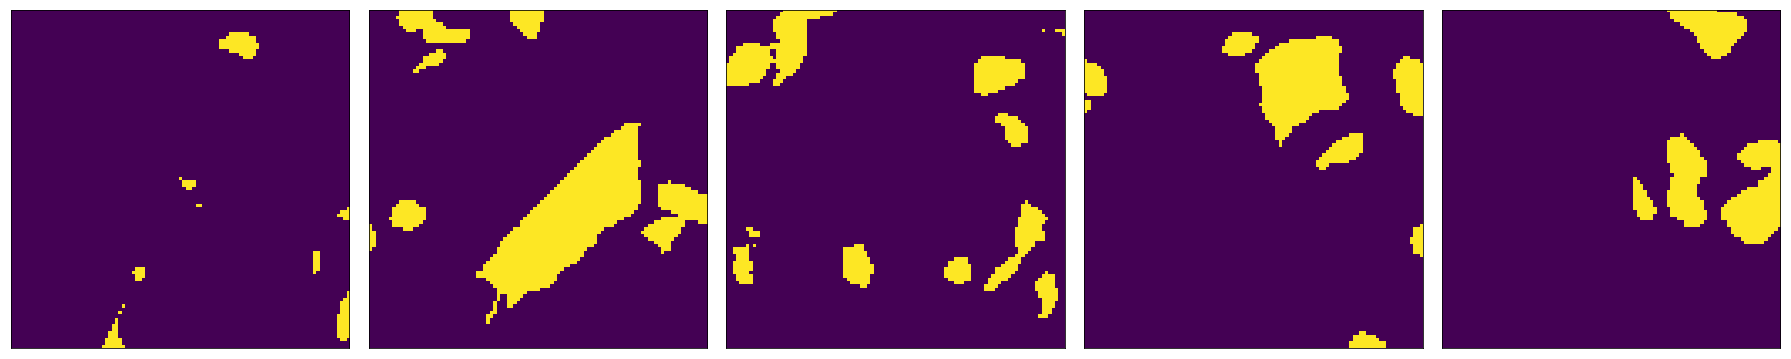

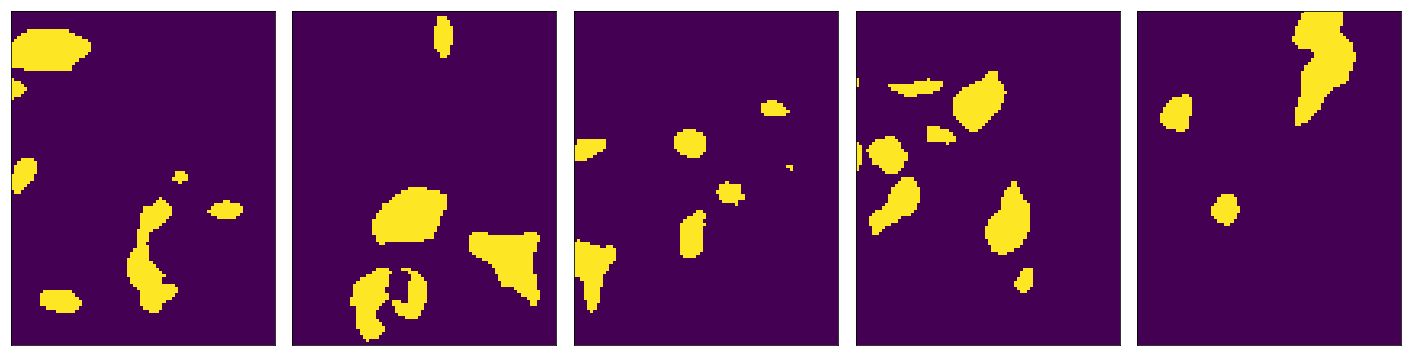

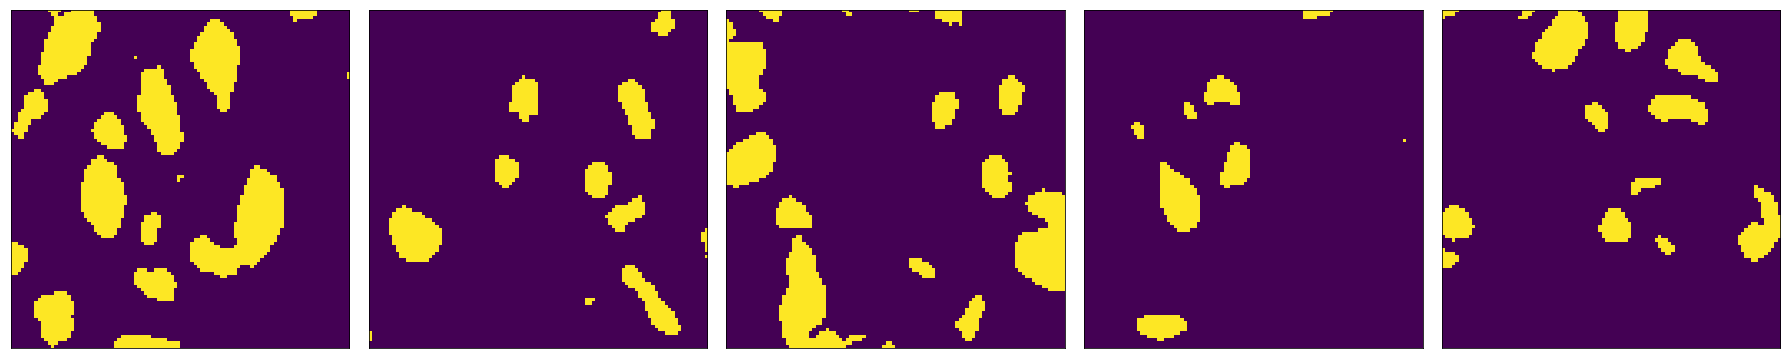

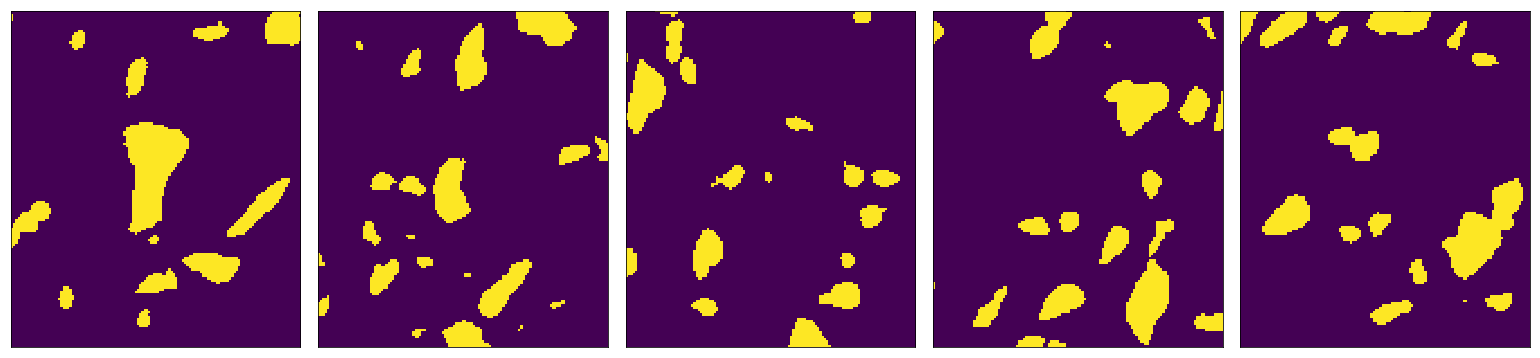

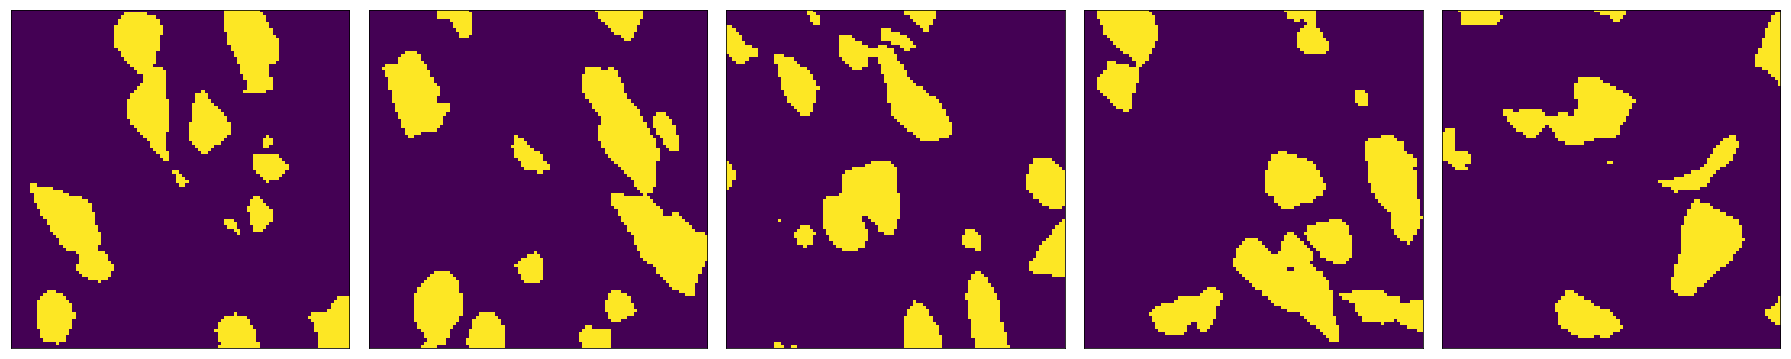

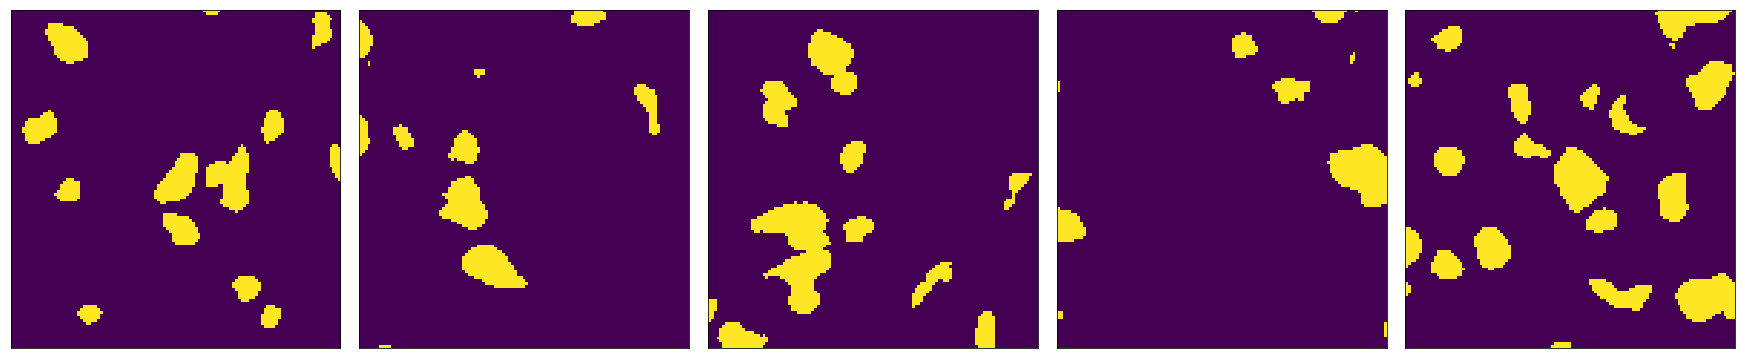

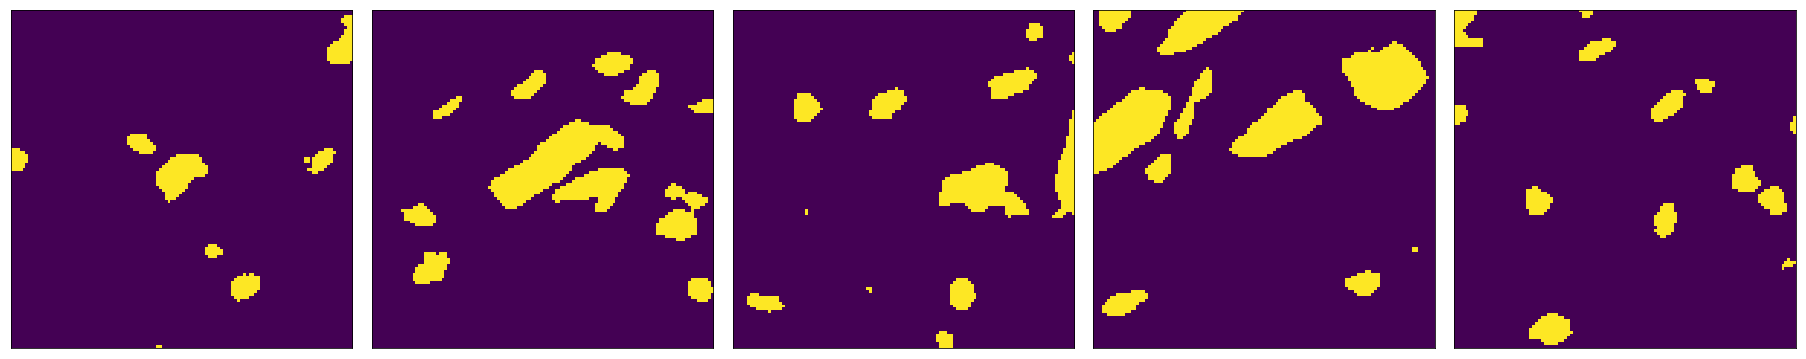

In [495]:
option_vis_blob_margion = 50
for tempBlobIndex in np.random.choice(range(n_blobs),10):
    display_images_in_grids([fun_crop_images(im_BW[secIndex],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margion),
                             fun_crop_images(im_BW[secIndex+1],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margion),
                             fun_crop_images(im_BW[secIndex+2],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margion),
                            fun_crop_images(im_BW[secIndex+3],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margion),
                            fun_crop_images(im_BW[secIndex+4],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margion)],
                            nc=5)
    

### Conclusion:
1. In terms of individual cells, it's hard to find cells similar with its in the next section. Similarity might shows up in a larger scale: the spatial organization of the neurons, some statistical properties of the neurons. 
2. The blob matching method matches blob locally, ignoring all of the structual information. 

Anyway, let's try to really find the matching cells. 

# Blob comparsion

/usr/local/lib/python2.7/dist-packages/skimage/filters/_gaussian.py:22: skimage_deprecation: Function ``gaussian_filter`` is deprecated. Use ``skimage.filters.gaussian`` instead.
  multichannel=None, preserve_range=False, truncate=4.0):


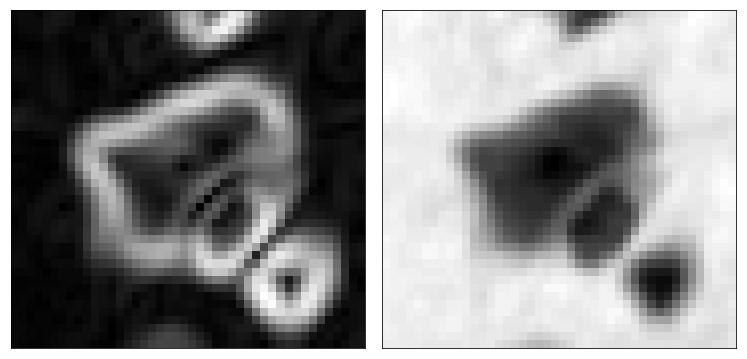

In [496]:
tempRegion1_oriIM = fun_crop_images(im_rescale[0],*tempRegion1.bbox,margin=10)
tempR1o_gradx, tempR1o_grady = scipy.gradient(skimage.filters.gaussian_filter(tempRegion1_oriIM,1))
tempR1o_grad = np.sqrt(tempR1o_gradx ** 2 + tempR1o_grady ** 2)
display_images_in_grids([tempR1o_grad,tempRegion1_oriIM],cmap=plt.cm.gray,nc=2)


In [485]:
temp_next_sec_range, local_cloc = fun_scan_range(tempR1_idx_loc,3*fun_radius_bbox(*tempRegion1.bbox),imcmax=imcmax,imrmax=imrmax)

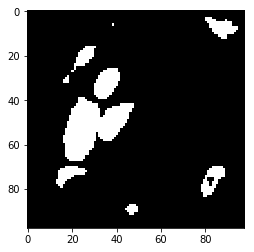

In [498]:
# Get the accorsponding part of the next section. 
secIndex_next = secIndex + 1;
if secIndex_next < n_images:
    temp_next_sec_image = fun_crop_images(im_BW[secIndex_next],*temp_next_sec_range,imrmax=imrmax,imcmax=imcmax)
    temp_next_sec_image = skimage.segmentation.clear_border(temp_next_sec_image)
    plt.imshow(temp_next_sec_image,cmap=plt.cm.gray)
else:
    sys.stderr('Reach the limit of stack. Break')

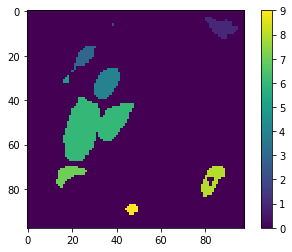

In [500]:
plt.imshow(temp_next_sec_image_label)
plt.colorbar()

In [501]:
temp_next_sec_image_label = skimage.measure.label(temp_next_sec_image)
temp_next_sec_image_blob_prop = skimage.measure.regionprops(temp_next_sec_image_label)

In [502]:
temp_next_blob_props = {}

temp_next_n_blob = len(temp_next_sec_image_blob_prop)
for tempProp in prop:
    temp_prop_value = []
    for blobIndex in range(temp_next_n_blob):
        temp_prop_value.append(temp_next_sec_image_blob_prop[blobIndex][tempProp])
    temp_next_blob_props[tempProp] = temp_prop_value
temp_next_blob_props['relative_dict'] = []
for blobIndex in range(temp_next_n_blob):
    temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_image_blob_prop[blobIndex]['centroid'],local_cloc))

In [503]:
temp_sim = {}
temp_compare_props = ['area', 'orientation', 'eccentricity']
for temp_prop in temp_compare_props:
    if temp_prop == 'orientation':
        temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                 temp_next_blob_props[temp_prop],distance_type='angular'))
    else:
        temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                 temp_next_blob_props[temp_prop]))

In [504]:
temp_compare_result = np.mean(np.stack(temp_sim.values()),axis=0)>0.7
temp_compare_result = any(temp_compare_result.tolist())

In [505]:
temp_compare_result

False

# Integrated - blob comparsion

In [570]:
secIndex = 0
sec = secIndexList[secIndex]
blobID = 142
n_blobs = len(im_blob_prop[sec])
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox']
compare_props = ['area', 'orientation', 'eccentricity']
compare_weight = [6,1,3]
compare_weight = np.array(weight)/ float(np.sum(weight))
o_simil_threshold = 0.7

im_blob_typical = {}
im_blob_sim_score = {}
for tempSecIndex in range(n_images):
    tempSec = secIndexList[tempSecIndex]
    tempN_blobs = len(im_blob_prop[tempSec])
    im_blob_typical[tempSec] = np.zeros((tempN_blobs,1),dtype=bool)
    im_blob_sim_score[tempSec] = np.zeros((tempN_blobs,1),dtype=float)
    
# tempRegion1 = im_blob_prop[sec][blobID]
for blobID in range(n_blobs):
    temp_curr_blob_props = {}

    for tempProp in prop:
        temp_curr_blob_props[tempProp] = im_blob_prop[sec][blobID][tempProp]

    tempR1_radius = fun_radius_bbox(*temp_curr_blob_props['bbox'])
    tempR1_idx_loc = temp_curr_blob_props['centroid']
    tempR1_orientation = temp_curr_blob_props['orientation']
    tempR1_hu = temp_curr_blob_props['moments_hu']
    tempR1_size = temp_curr_blob_props['area']

    temp_next_sec_range, local_cloc = fun_scan_range(tempR1_idx_loc,3*fun_radius_bbox(*temp_curr_blob_props['bbox']),imcmax=imcmax,imrmax=imrmax)

    # Get the accorsponding part of the next section. 
    secIndex_next = secIndex + 1;
    if secIndex_next < n_images:
        temp_next_sec_image = fun_crop_images(im_BW[secIndex_next],*temp_next_sec_range,imrmax=imrmax,imcmax=imcmax)
        temp_next_sec_image = skimage.segmentation.clear_border(temp_next_sec_image)
    #     plt.imshow(temp_next_sec_image,cmap=plt.cm.gray)
    else:
        sys.stderr('Reach the limit of stack. Next...')
        continue

    temp_next_sec_image_label = skimage.measure.label(temp_next_sec_image)
    temp_next_sec_image_blob_prop = skimage.measure.regionprops(temp_next_sec_image_label)

    temp_next_blob_props = {}

    temp_next_n_blob = len(temp_next_sec_image_blob_prop)
    if temp_next_n_blob > 0:
        for tempProp in prop:
            temp_prop_value = []
            for blobIndex in range(temp_next_n_blob):
                temp_prop_value.append(temp_next_sec_image_blob_prop[blobIndex][tempProp])
            temp_next_blob_props[tempProp] = temp_prop_value
        temp_next_blob_props['relative_dict'] = []
        for blobIndex in range(temp_next_n_blob):
            temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_image_blob_prop[blobIndex]['centroid'],local_cloc))

        temp_sim = {}
        compare_props = ['area', 'orientation', 'eccentricity']
        for temp_prop in compare_props:
            if temp_prop == 'orientation':
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop],distance_type='angular'))
            else:
                temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                         temp_next_blob_props[temp_prop]))

        temp_compare_score = np.dot(np.transpose(np.stack(temp_sim.values())),compare_weight)
        temp_compare_result = temp_compare_score > o_simil_threshold
        temp_compare_result = any(temp_compare_result.tolist())
        im_blob_sim_score[sec][blobID] = np.max(temp_compare_score).flatten()
        im_blob_typical[sec][blobID] = temp_compare_result


In [599]:
temp_num_blob_matched = np.count_nonzero(im_blob_typical[200])
temp_matched_blob_index = np.nonzero(im_blob_typical[200])[0].tolist()

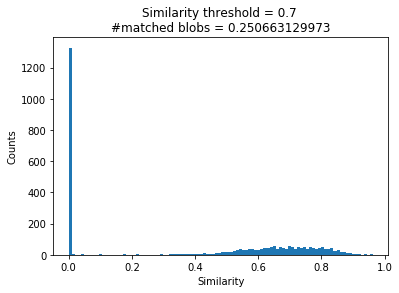

In [594]:
# Statistics
temp_num_blob_matched = np.count_nonzero(im_blob_typical[sec])/float(n_blobs)
fig_hist_simscore_sec200 = plt.figure();
fig_hist_simscore_sec200 = plt.hist(im_blob_sim_score[200],bins=100);
fig_hist_simscore_sec200 = plt.xlabel('Similarity')
fig_hist_simscore_sec200 = plt.ylabel('Counts')
fig_hist_simscore_sec200 = plt.title('Similarity threshold = %s \n#matched blobs = %s'% (o_simil_threshold,temp_num_blob_matched))

[5,
 6,
 7,
 10,
 13,
 16,
 28,
 29,
 34,
 37,
 38,
 41,
 43,
 48,
 49,
 54,
 56,
 57,
 60,
 67,
 70,
 71,
 72,
 74,
 75,
 84,
 86,
 87,
 89,
 90,
 94,
 98,
 104,
 117,
 118,
 120,
 123,
 126,
 128,
 130,
 132,
 133,
 135,
 139,
 140,
 146,
 152,
 161,
 162,
 164,
 166,
 168,
 169,
 170,
 176,
 182,
 184,
 190,
 192,
 196,
 203,
 206,
 207,
 210,
 212,
 215,
 221,
 226,
 227,
 232,
 233,
 236,
 237,
 240,
 244,
 247,
 249,
 251,
 256,
 259,
 263,
 265,
 267,
 270,
 271,
 277,
 278,
 279,
 283,
 285,
 287,
 293,
 300,
 301,
 302,
 303,
 307,
 309,
 312,
 314,
 318,
 319,
 324,
 326,
 327,
 328,
 333,
 335,
 336,
 338,
 349,
 350,
 353,
 357,
 358,
 359,
 367,
 369,
 371,
 374,
 376,
 379,
 380,
 383,
 384,
 385,
 388,
 393,
 400,
 401,
 405,
 416,
 417,
 430,
 438,
 439,
 441,
 447,
 452,
 454,
 458,
 461,
 462,
 463,
 464,
 465,
 466,
 467,
 472,
 473,
 474,
 486,
 488,
 490,
 491,
 495,
 497,
 501,
 502,
 509,
 520,
 521,
 523,
 526,
 532,
 533,
 538,
 539,
 540,
 545,
 548,
 549,
 55

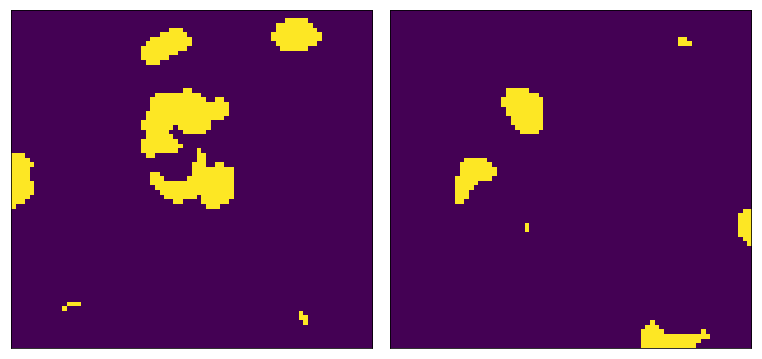

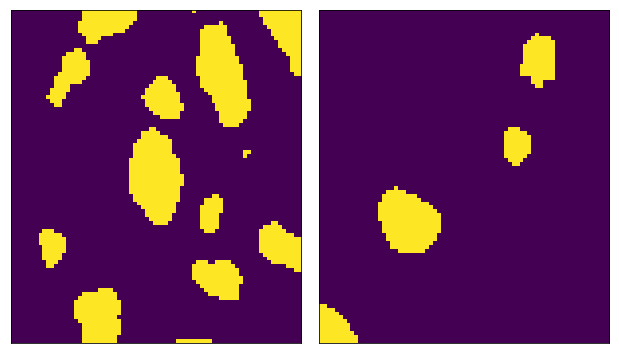

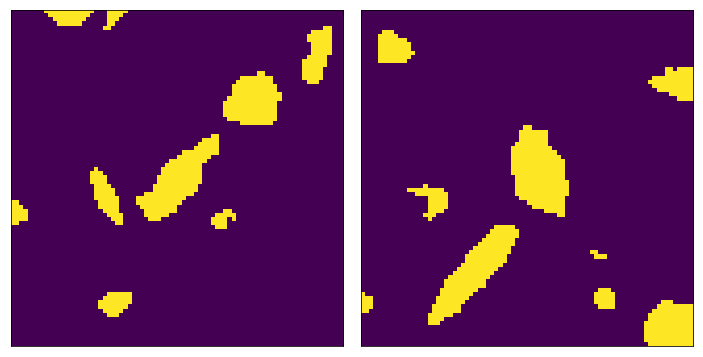

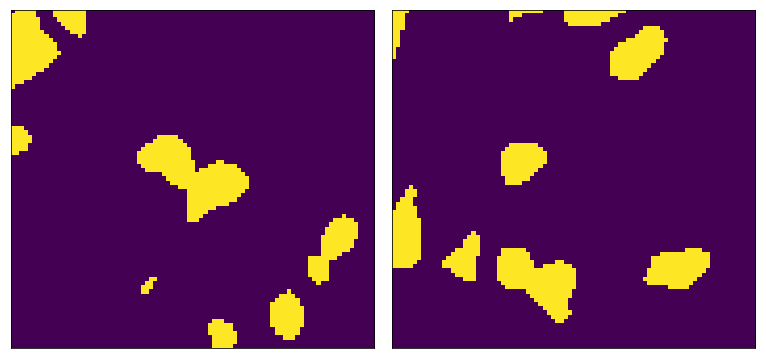

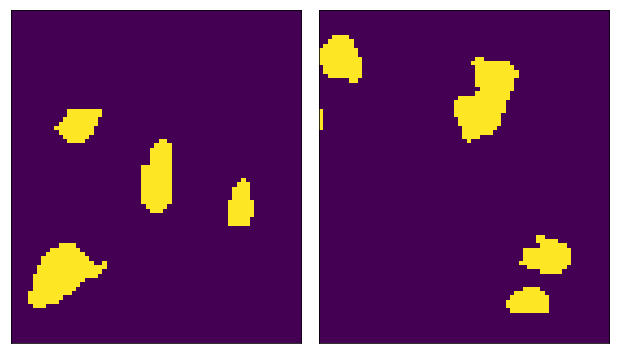

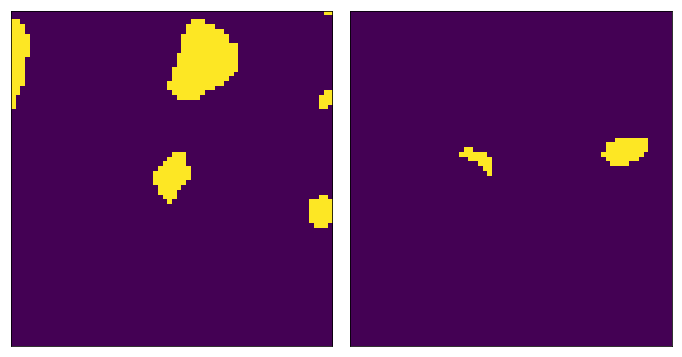

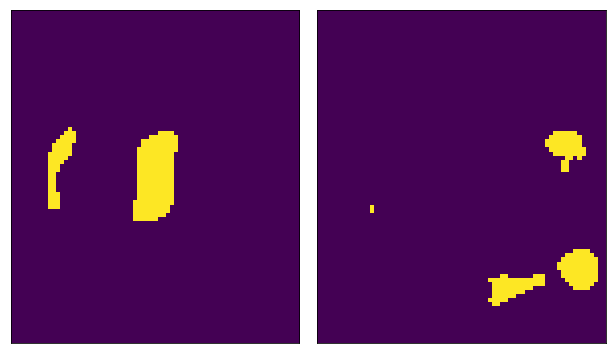

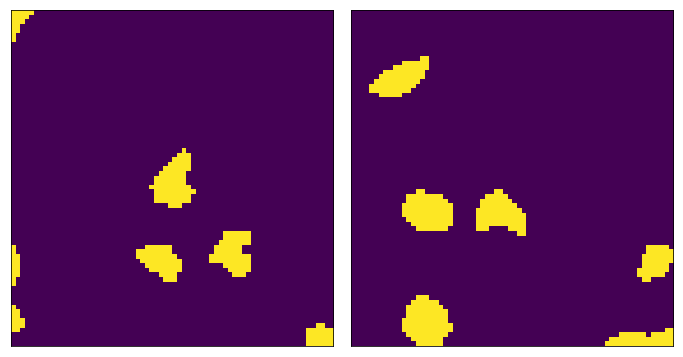

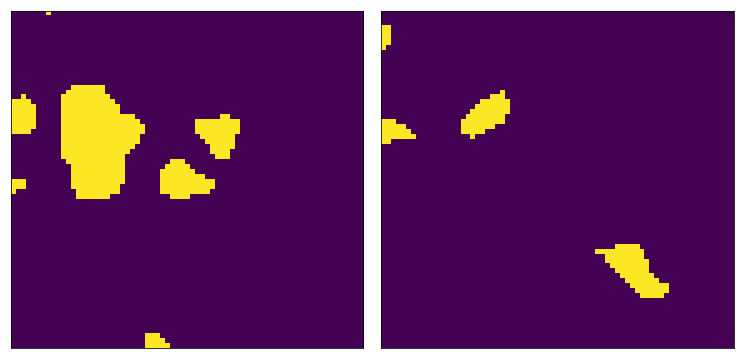

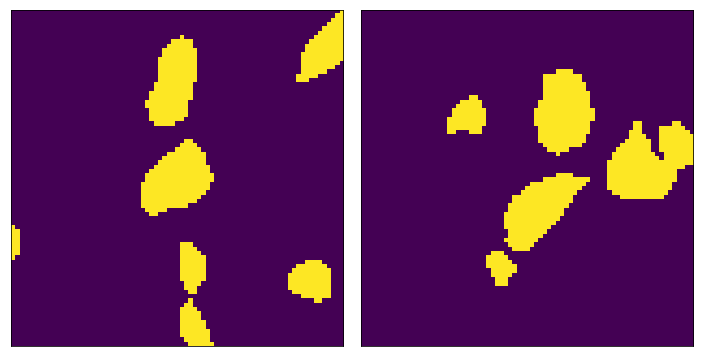

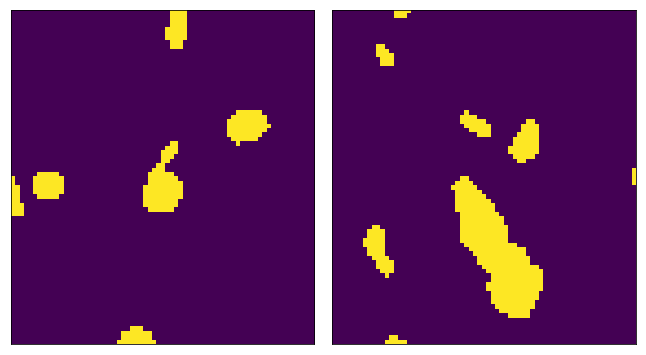

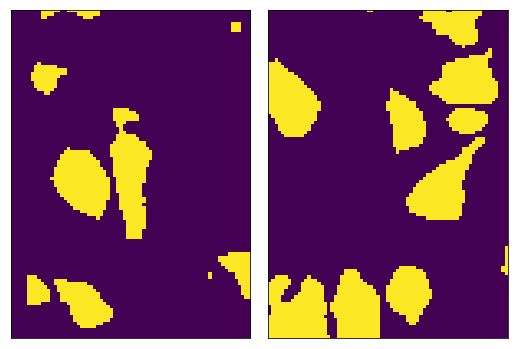

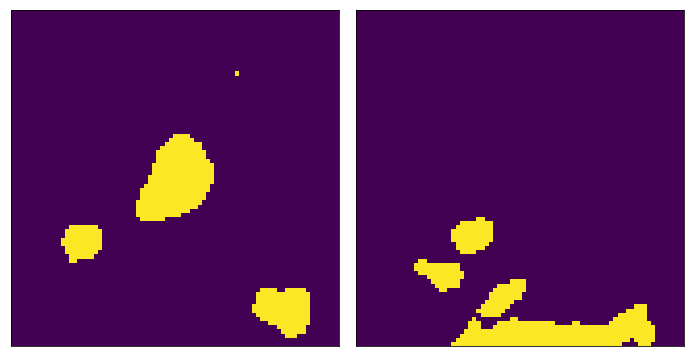

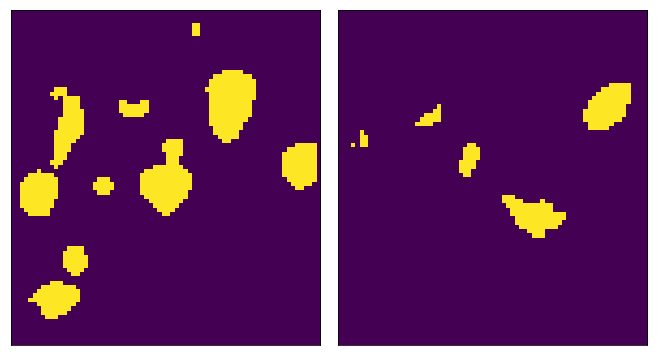

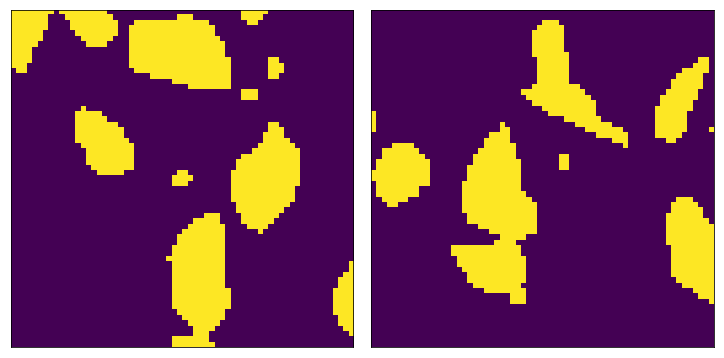

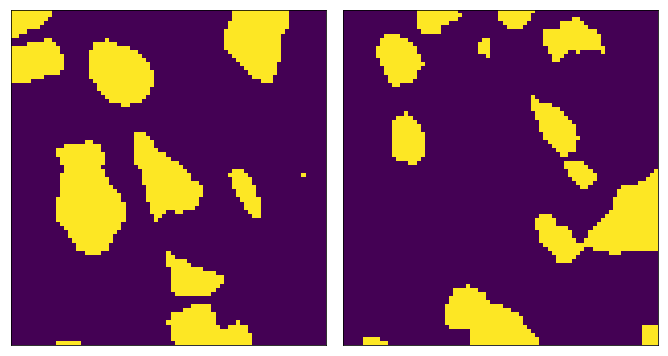

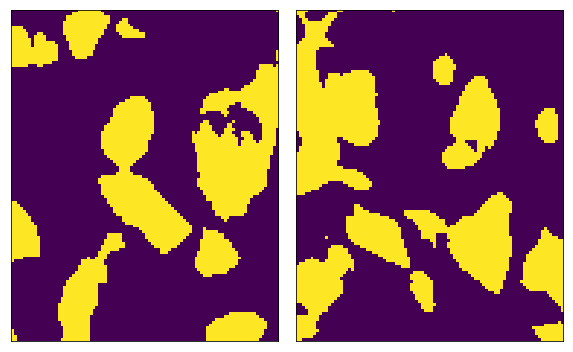

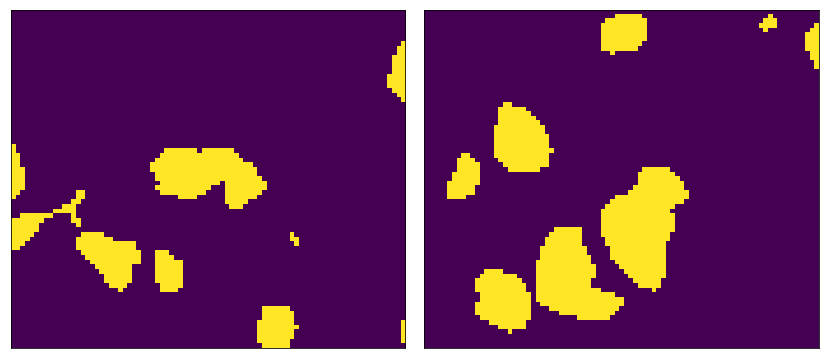

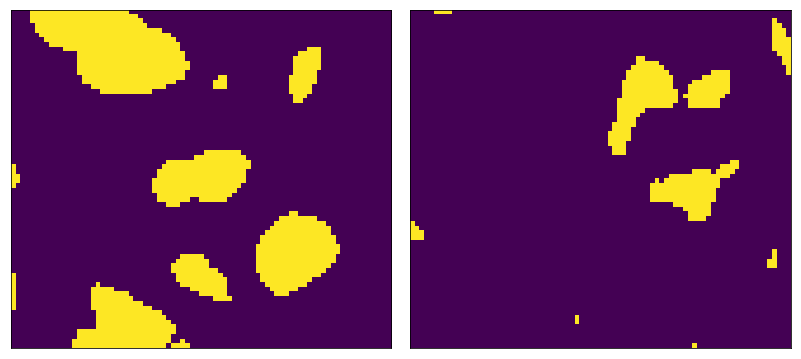

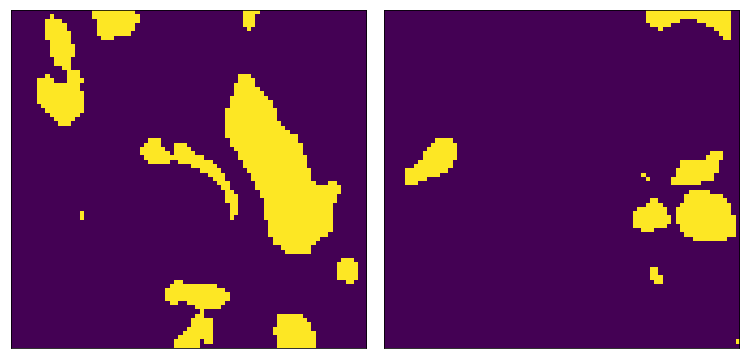

In [604]:
# Check if really similar
option_vis_blob_margion = 30
for tempBlobIndex in np.random.choice(temp_matched_blob_index,20):
    display_images_in_grids([fun_crop_images(im_BW[secIndex],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margion),
                             fun_crop_images(im_BW[secIndex+1],*im_blob_prop[sec][tempBlobIndex]['bbox'],margin=option_vis_blob_margion)],
                            nc=2)

In [609]:
temp_match_blob_pos = [im_blob_prop[sec][index][''] for index in temp_matched_blob_index]

[(11.908396946564885, 359.26717557251908),
 (12.177777777777777, 110.59999999999999),
 (12.168831168831169, 1945.8701298701299),
 (20.77403846153846, 306.95192307692309),
 (24.561368209255534, 1592.5674044265593),
 (25.414814814814815, 241.58148148148149),
 (30.089068825910932, 40.777327935222672),
 (27.715151515151515, 856.030303030303),
 (26.450704225352112, 606.02816901408448),
 (35.385844748858446, 759.02511415525112),
 (32.216216216216218, 1710.0135135135135),
 (35.725274725274723, 17.326007326007325),
 (35.865497076023395, 1417.8830409356726),
 (37.422924901185773, 163.50592885375494),
 (39.107692307692311, 461.7923076923077),
 (34.279069767441861, 1927.0),
 (51.511278195488721, 1749.5639097744361),
 (41.591743119266056, 1962.5825688073394),
 (42.0, 1627.3857142857144),
 (52.507422402159243, 119.52361673414305),
 (55.921290322580646, 77.549677419354836),
 (49.702702702702702, 624.47297297297303),
 (53.911262798634809, 783.0273037542662),
 (48.289029535864977, 1569.8080168776371),